In [28]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
NROWS = 200000

In [29]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [30]:
trades = pd.read_csv(PATH_TO_FILE+'trades.csv', nrows=100000)

In [31]:
trades.head(20)

,receive_ts,exchange_ts,aggro_side,price,size
0,1655942402624789714,1655942402623000000,BID,19977.5,0.001
1,1655942405293556247,1655942405292000000,BID,19977.5,0.041
2,1655942405293628020,1655942405292000000,BID,19977.5,0.036
3,1655942405293832021,1655942405292000000,BID,19977.5,0.001
4,1655942405293929517,1655942405292000000,BID,19977.5,0.001
5,1655942405294003345,1655942405292000000,BID,19977.8,0.003
6,1655942405294140676,1655942405292000000,BID,19977.9,0.003
7,1655942405294206928,1655942405292000000,BID,19978.0,0.001
8,1655942408891268324,1655942408890000000,ASK,19977.9,0.020
9,1655942409197011118,1655942409193000000,BID,19978.0,0.058


In [32]:
len(set(trades.exchange_ts))

35350

In [33]:
len(set(trades.receive_ts))

100000

In [34]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [35]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta

strategy = BestPosStrategy(delay, hold_time)

In [36]:
trades_list, md_list, updates_list = strategy.run(sim)

In [37]:
df = get_pnl(updates_list)

In [38]:
dt = pd.to_datetime(df.receive_ts)

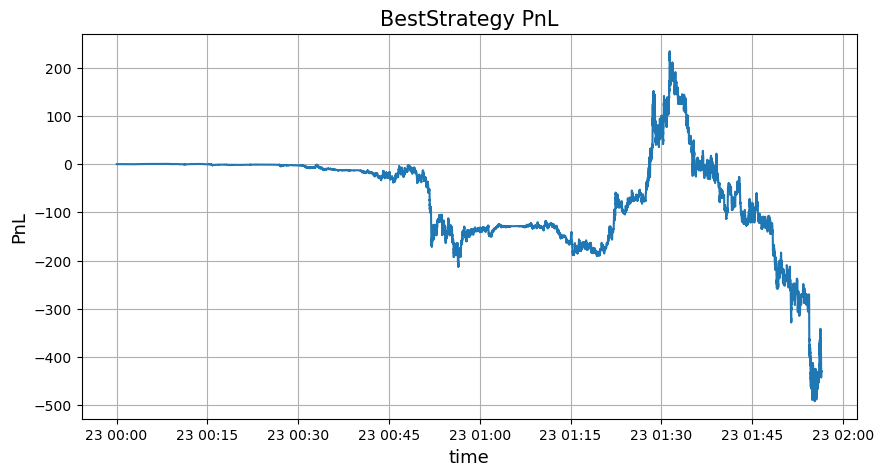

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [45]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [46]:
from simulator import MdUpdate, OrderbookSnapshotUpdate, AnonTrade

from get_info import md_to_dataframe, trade_to_dataframe

In [47]:
def generate_sample_data(n_points):
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    order_books_md = [ MdUpdate(i, i, OrderbookSnapshotUpdate(i, i, [(ask_price, size)], [(bid_price, size)]), None)
                     for i in range(n_points) ]
    
    
    trades = []
    p = 1 / 2
    trade_id = np.random.choice([0, 1], size=n_points, p=[1-p, p])
    for i in range(n_points):
        
        if trade_id[i]:
            
            side = np.random.choice([0, 1], size=1)[0]
            price = bid_price if side else ask_price
            side = "ASK" if side else "BID" 
            trade = AnonTrade(i, i, side, size, price)
            trades.append(trade)

    return order_books_md, trades

In [60]:
order_books_md, trades = generate_sample_data(100)

trades_md = [ MdUpdate(trade.exchange_ts, trade.receive_ts, None, trade ) for trade in trades ]

md = order_books_md + trades_md
md = sorted(md, key = lambda x: x.exchange_ts)

In [61]:
trades

[AnonTrade(exchange_ts=1, receive_ts=1, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=3, receive_ts=3, side='BID', size=1, price=101.0),
 AnonTrade(exchange_ts=5, receive_ts=5, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=6, receive_ts=6, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=8, receive_ts=8, side='BID', size=1, price=101.0),
 AnonTrade(exchange_ts=9, receive_ts=9, side='BID', size=1, price=101.0),
 AnonTrade(exchange_ts=10, receive_ts=10, side='BID', size=1, price=101.0),
 AnonTrade(exchange_ts=11, receive_ts=11, side='BID', size=1, price=101.0),
 AnonTrade(exchange_ts=12, receive_ts=12, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=15, receive_ts=15, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=17, receive_ts=17, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=18, receive_ts=18, side='ASK', size=1, price=99.0),
 AnonTrade(exchange_ts=21, receive_ts=21, side='BID', size=1, price=101.0),
 AnonTrade(exchange_ts=22, rece

In [62]:
md

[MdUpdate(exchange_ts=0, receive_ts=0, orderbook=OrderbookSnapshotUpdate(exchange_ts=0, receive_ts=0, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=OrderbookSnapshotUpdate(exchange_ts=1, receive_ts=1, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=None, trade=AnonTrade(exchange_ts=1, receive_ts=1, side='ASK', size=1, price=99.0)),
 MdUpdate(exchange_ts=2, receive_ts=2, orderbook=OrderbookSnapshotUpdate(exchange_ts=2, receive_ts=2, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=3, receive_ts=3, orderbook=OrderbookSnapshotUpdate(exchange_ts=3, receive_ts=3, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=3, receive_ts=3, orderbook=None, trade=AnonTrade(exchange_ts=3, receive_ts=3, side='BID', size=1, price=101.0)),
 MdUpdate(exchange_ts=4, receive_ts=4, orderbook=OrderbookSnapshotUpdate(exchange_ts=4, receive_ts=4, asks=[(101.0, 1)]

In [81]:
latency = pd.Timedelta(1, 'ns').delta
md_latency = pd.Timedelta(1, 'ns').delta

sim = Sim(md, latency, md_latency)

In [82]:
#delay between orders
delay = pd.Timedelta(10, 'ns').delta

hold_time = pd.Timedelta(1000, 'ns').delta

strategy = BestPosStrategy(delay, hold_time)

In [83]:
trades_list, md_list, updates_list = strategy.run(sim)

In [84]:
sim.ready_to_execute_orders

{}

In [85]:
sim.best_bid

99.0

In [86]:
trades_list

[OwnTrade(exchange_ts=10, receive_ts=11, trade_id=0, order_id=0, side='BID', size=0.001, price=99.0),
 OwnTrade(exchange_ts=10, receive_ts=11, trade_id=1, order_id=1, side='ASK', size=0.001, price=101.0),
 OwnTrade(exchange_ts=20, receive_ts=21, trade_id=2, order_id=2, side='BID', size=0.001, price=99.0),
 OwnTrade(exchange_ts=20, receive_ts=21, trade_id=3, order_id=3, side='ASK', size=0.001, price=101.0),
 OwnTrade(exchange_ts=30, receive_ts=31, trade_id=4, order_id=4, side='BID', size=0.001, price=99.0),
 OwnTrade(exchange_ts=30, receive_ts=31, trade_id=5, order_id=5, side='ASK', size=0.001, price=101.0),
 OwnTrade(exchange_ts=40, receive_ts=41, trade_id=6, order_id=6, side='BID', size=0.001, price=99.0),
 OwnTrade(exchange_ts=40, receive_ts=41, trade_id=7, order_id=7, side='ASK', size=0.001, price=101.0),
 OwnTrade(exchange_ts=50, receive_ts=51, trade_id=8, order_id=8, side='BID', size=0.001, price=99.0),
 OwnTrade(exchange_ts=50, receive_ts=51, trade_id=9, order_id=9, side='ASK', s

In [87]:
updates_list 

[MdUpdate(exchange_ts=0, receive_ts=0, orderbook=OrderbookSnapshotUpdate(exchange_ts=0, receive_ts=0, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=OrderbookSnapshotUpdate(exchange_ts=1, receive_ts=1, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=None, trade=AnonTrade(exchange_ts=1, receive_ts=1, side='ASK', size=1, price=99.0)),
 MdUpdate(exchange_ts=2, receive_ts=2, orderbook=OrderbookSnapshotUpdate(exchange_ts=2, receive_ts=2, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=3, receive_ts=3, orderbook=OrderbookSnapshotUpdate(exchange_ts=3, receive_ts=3, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=3, receive_ts=3, orderbook=None, trade=AnonTrade(exchange_ts=3, receive_ts=3, side='BID', size=1, price=101.0)),
 MdUpdate(exchange_ts=4, receive_ts=4, orderbook=OrderbookSnapshotUpdate(exchange_ts=4, receive_ts=4, asks=[(101.0, 1)]

In [88]:
trades_df = trade_to_dataframe(trades_list)

trades_ts = trades_df.receive_ts
trades_prices = trades_df.price

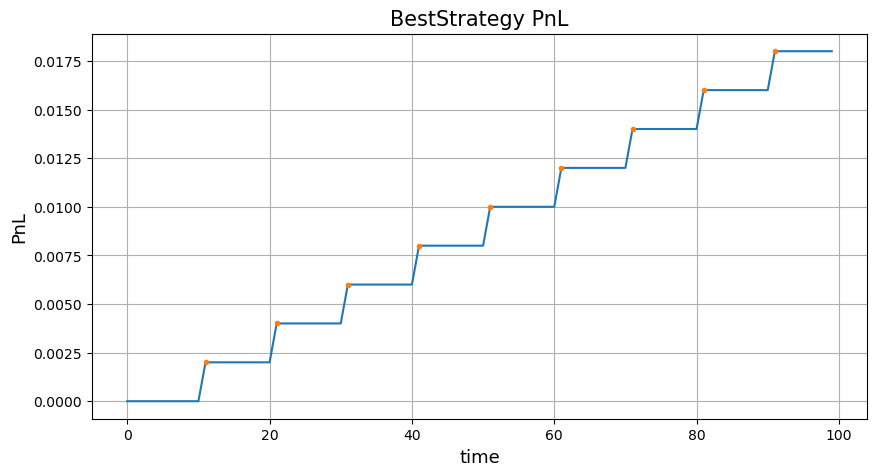

In [90]:
df = get_pnl(updates_list)

dt = df.receive_ts

plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.plot(trades_ts, df.total[trades_ts.values], '.')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()